# Predicting traffic impact using environmental crash data:
---

<br>

## Overview:


This dataset contains 4 years worth of crash data from across the US. 

The question I've set out to answer is: Can environmental crash data be used to predict the crash's traffic impact? 

# Imports:
---

<small>Original dataset: https://www.kaggle.com/sobhanmoosavi/us-train


In its original form this file caused Colab to crash when attempting upload. To make the file smaller several irrelevant or mostly null columns (including Street, Number, End_Lat, End_Lng, City & County) were removed in Excel. 

In [ ]:
# import pandas as pd
# pd.options.mode.chained_assignment = None  # default='warn'
# import io
# import matplotlib.pyplot as plt
# import numpy as np

# import seaborn as sns

# from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
# from sklearn.metrics import classification_report, plot_confusion_matrix 
# from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# !pip install xgboost
# from xgboost import XGBClassifier

# !pip install scikit-optimize
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer
# from imblearn.combine import SMOTEENN
# from scipy.stats.mstats import winsorize
# from sklearn.metrics import recall_score, precision_score

# from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# !pip install PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
# downloaded = drive.CreateFile({'id': '1bOmTNBomNCicD8zpz-KOol11HwwUu-y_'})
# downloaded.GetContentFile('accidents.xlsx')

In [ ]:
# df = pd.read_excel('accidents.xlsx')

In [ ]:
# get a random sample of the data to work with 
data = df.sample(frac=.1)

# Functions:
---

In [ ]:
def missingness_summary(df, print_log, sort):
  '''
  Return a pandas series containing the percentage of missing data in each column.
  
  Args:
  df - pandas dataframe 

  print_log (boolean) - if True, print out all of the columns in the dataframe, 
    one to a line, followed by the percentage of total rows that have a 
    null value for that column.
    
  sort (string) - specify if the output should be sorted in ascending order, 
    descending order, or not at all.
  '''
  if print_log == True:
    series = pd.Series(df.isnull().sum()*100/df.isnull().count())
    if sort == 'Ascending':
      series = series.sort_values(ascending = True)
    elif sort == 'Descending':
      series = series.sort_values(ascending=False)
    else:
      series
    return series

In [ ]:
def fill_with_mean(missing_nums, df):
  for i in missing_nums:
    df[i] = df[i].fillna(df[i].mean())

In [ ]:
def fill_with_mode(missing_objs, df):
  for i in missing_objs:
    df[i] = df[i].fillna(df[i].value_counts().index[0])

In [ ]:
def fill_test_with_train_mean(columns, train, test):
  for i in columns:
    train_mean = train[i].mean()
    test[i] = test[i].fillna(train_mean)


In [ ]:
def fill_test_with_train_mode(columns, train, test):
  for i in columns:
    train_mode = train[i].value_counts().index[0]
    test[i] = test[i].fillna(train_mode)

In [ ]:
def print_score(model, X_train, X_test, y_train, y_test):
  print('Training:\n', model.score(X_train, y_train))
  print('Testing:\n', model.score(X_test, y_test))

In [ ]:
def print_classif_rep(model, X_train, X_test, y_train, y_test):
  print('Training:\n', classification_report(y_train, model.predict(X_train)))
  print('Testing:\n', classification_report(y_test, model.predict(X_test)))

In [ ]:
def get_high_corrs(df):
  corrs = df.corr()
  selected_columns = []
  for i in corrs.columns:
    for j in corrs[i].values:
      if j >= .9 and j != 1:
        selected_columns.append(i)
  return selected_columns

In [ ]:
def print_score(model, score_type, X_train, X_test, y_train, y_test):
  print('Train score: ', round(score_type(y_train, model.predict(X_train)), 2))
  print('Test score: ', round(score_type(y_test, model.predict(X_test)), 2))

# Data exploration and cleaning:
---

In [ ]:
data.shape

(104858, 37)

In [ ]:
data.head()

,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Side,State,Zipcode,Timezone,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
187164,201,3,2016-09-19 12:04:14,2016-09-19 13:04:14,42.386120,-83.020172,0.00,R,MI,48213,US/Eastern,77.0,NaN,58.0,30.05,10.0,SSW,5.8,NaN,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
964672,201,3,2019-09-07 22:52:05,2019-09-07 23:21:21,35.980438,-83.937401,0.00,R,TN,37921,US/Eastern,74.0,74.0,64.0,28.94,10.0,NNE,3.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
303542,201,3,2016-07-11 08:13:32,2016-07-11 08:58:32,32.790867,-96.755981,0.00,R,TX,75223,US/Central,80.1,NaN,76.0,29.89,10.0,South,16.1,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
171036,201,3,2016-11-04 11:48:11,2016-11-04 12:32:56,38.748219,-90.439575,0.01,R,MO,63043,US/Central,63.0,NaN,54.0,30.45,10.0,ESE,3.5,NaN,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
103217,201,2,2016-04-20 14:49:15,2016-04-20 15:49:15,34.163368,-118.472435,0.01,R,CA,91403,US/Pacific,87.1,NaN,8.0,29.88,10.0,SE,11.5,NaN,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


In [ ]:
# divide into train and test
train = data.sample(frac=.8)
test = data.drop(train.index)

In [ ]:
print(train.shape)
print(test.shape)

(83886, 37)
(20972, 37)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83886 entries, 938719 to 765641
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   TMC                    83886 non-null  int64         
 1   Severity               83886 non-null  int64         
 2   Start_Time             83886 non-null  datetime64[ns]
 3   End_Time               83886 non-null  datetime64[ns]
 4   Start_Lat              83886 non-null  float64       
 5   Start_Lng              83886 non-null  float64       
 6   Distance(mi)           83886 non-null  float64       
 7   Side                   83886 non-null  object        
 8   State                  83886 non-null  object        
 9   Zipcode                83869 non-null  object        
 10  Timezone               83835 non-null  object        
 11  Temperature(F)         82660 non-null  float64       
 12  Wind_Chill(F)          46940 non-null  float64       


Temperature(F) and Wind_Chill(F) have high colinearity. I'll explore more before deciding to remove one or make an interaction. 

In [ ]:
# Check programatically for strong correlations
get_high_corrs(train)

['Temperature(F)', 'Wind_Chill(F)']

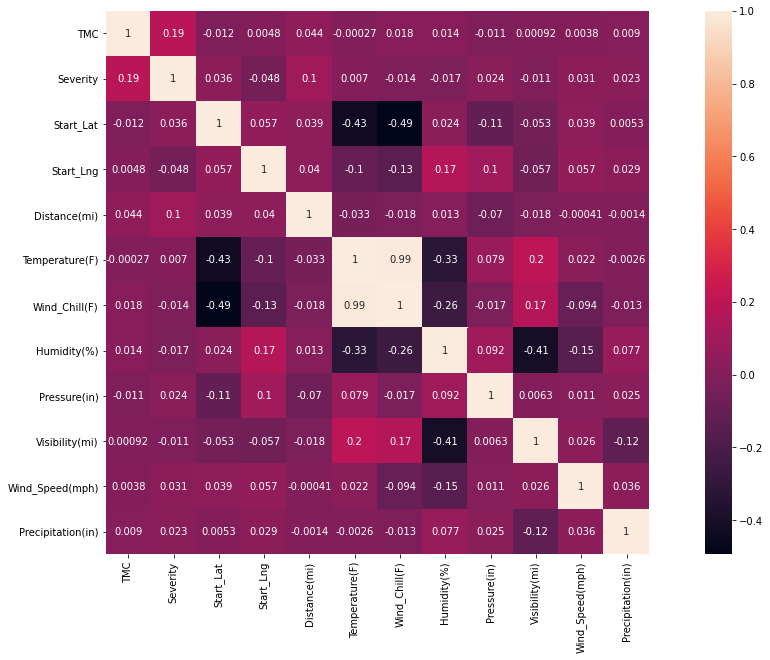

In [ ]:
# check for correlations with heatmat
nums = train.select_dtypes(include=['int64', 'float64'])
cormat = nums.corr()
plt.figure(figsize=(20,10))
ax = sns.heatmap(cormat, square=True, annot=True)

In [ ]:
# check percent missing values
missingness_summary(train, True, 'Descending')

Precipitation(in)        45.740648
Wind_Chill(F)            44.043106
Wind_Speed(mph)           9.611854
Visibility(mi)            1.866819
Weather_Condition         1.792909
Humidity(%)               1.628400
Temperature(F)            1.461507
Wind_Direction            1.424552
Pressure(in)              1.180173
Timezone                  0.060797
Zipcode                   0.020266
Nautical_Twilight         0.007153
Astronomical_Twilight     0.007153
Civil_Twilight            0.007153
Sunrise_Sunset            0.007153
Give_Way                  0.000000
Crossing                  0.000000
Severity                  0.000000
Start_Time                0.000000
End_Time                  0.000000
Start_Lat                 0.000000
Start_Lng                 0.000000
Distance(mi)              0.000000
Side                      0.000000
State                     0.000000
Turning_Loop              0.000000
Traffic_Signal            0.000000
Traffic_Calming           0.000000
Stop                

Since Wind_Chill(F) has more than 10% missing data, this solves my colinearity problem. I'll drop Wind_Chill(F) and keep Temperature(F) 

In [ ]:
# drop columns with more than 10% missing data
train.drop(['Precipitation(in)', 'Wind_Chill(F)', 'Wind_Speed(mph)'], axis=1, inplace=True)
test.drop(['Precipitation(in)', 'Wind_Chill(F)', 'Wind_Speed(mph)'], axis=1, inplace=True)

In [ ]:
train.shape

(83886, 34)

In [ ]:
# drop rows with more than 20% missing data
train.dropna(thresh=27, inplace=True)
test.dropna(thresh=27, inplace=True)

In [ ]:
# check how many rows were dropped (less than .02% of the rows)
train.shape[0]

83869

In [ ]:
# fill numeric nulls with column mean
missing_nums = train.select_dtypes(include=[int, float])

fill_with_mean(missing_nums, train)

# use mean from training set to fill nulls in test set
fill_test_with_train_mean(missing_nums, train, test)

In [ ]:
# fill categorical nulls with column mode
missing_objs = train.select_dtypes(exclude=[int, float])

fill_with_mode(missing_objs, train)

# use mode from training set to fill nulls in test set
fill_test_with_train_mode(missing_objs, train, test)

In [ ]:
# check for remaining nulls
train.isnull().sum().sort_values(ascending=False)

Astronomical_Twilight    0
State                    0
Visibility(mi)           0
Pressure(in)             0
Humidity(%)              0
Temperature(F)           0
Timezone                 0
Zipcode                  0
Side                     0
Nautical_Twilight        0
Distance(mi)             0
Start_Lng                0
Start_Lat                0
End_Time                 0
Start_Time               0
Severity                 0
Wind_Direction           0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
Turning_Loop             0
Sunrise_Sunset           0
Civil_Twilight           0
TMC                      0
dtype: int64

In [ ]:
train.nunique().sort_values(ascending=False)

End_Time                 83652
Start_Time               83638
Start_Lat                61813
Start_Lng                61336
Zipcode                  29091
Distance(mi)              1270
Pressure(in)               771
Temperature(F)             546
Humidity(%)                 99
Weather_Condition           74
State                       47
Visibility(mi)              44
Wind_Direction              24
TMC                         20
Severity                     4
Timezone                     4
Crossing                     2
Bump                         2
Civil_Twilight               2
Sunrise_Sunset               2
Traffic_Signal               2
Traffic_Calming              2
Side                         2
Stop                         2
Station                      2
Roundabout                   2
Railway                      2
No_Exit                      2
Junction                     2
Give_Way                     2
Nautical_Twilight            2
Amenity                      2
Astronom

In [ ]:
# Drop categorical columns that have too many (or only 1) unique values

train.drop(['Turning_Loop','TMC', 'Zipcode', 'Start_Lat', 'Start_Lng'], axis=1, inplace=True)
test.drop(['Turning_Loop','TMC', 'Zipcode', 'Start_Lat', 'Start_Lng'], axis=1, inplace=True)

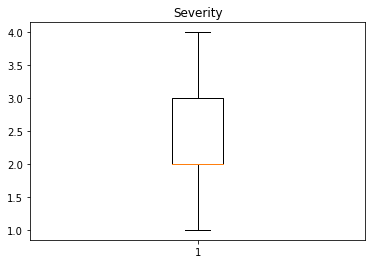

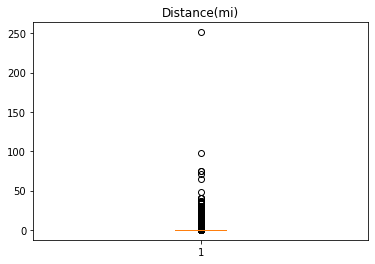

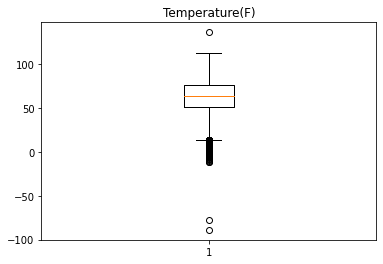

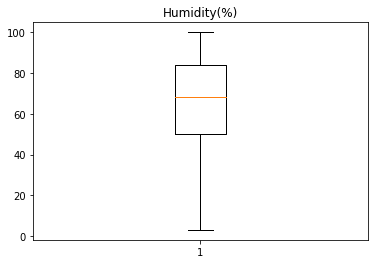

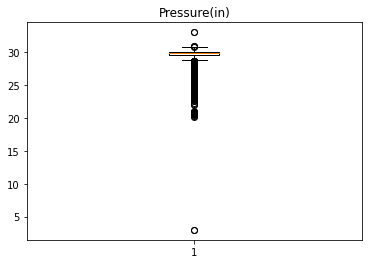

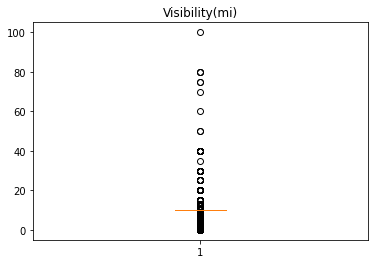

In [ ]:
# check for outliers with boxplots
nums = train.select_dtypes(include=['int64', 'float64'])
for i in nums:
  plt.boxplot(nums[i], whis=1.5)
  plt.title(i)
  plt.show()

In [ ]:
# Pressure and Temperature have a few extreme outliers that appear to be errors 
# so I'll drop those values
train = train[train['Temperature(F)'] > -50]
train = train[train['Temperature(F)'] < 150]
train = train[train['Pressure(in)'] > 15]

In [ ]:
train.shape[0]

83865

In [ ]:
# winsorize outliers for 'Pressure(in)'
def winsorize_outliers(df, cols, limits):
  for i in cols:
    df[i] = winsorize(df[i], limits=limits)

winsorize_outliers(train, ['Pressure(in)'], (.05, 0))

train_min = train['Pressure(in)'].min()

# replace test outliers for 'Pressure(in)' with train min
for i in test['Pressure(in)']:
  if i < train_min:
    test['Pressure(in)'] = test['Pressure(in)'].replace(i, train_min)

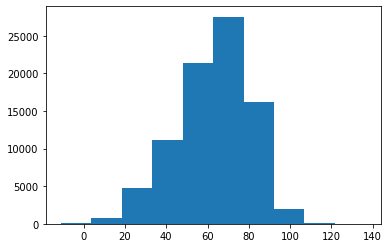

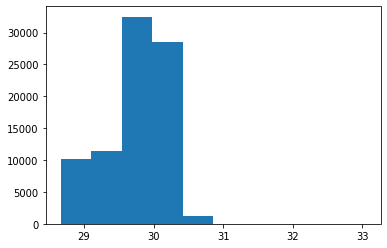

In [ ]:
# look at distributions for adjusted features
plt.hist(train['Temperature(F)'])
plt.show()

plt.hist(train['Pressure(in)'])
plt.show()

In [ ]:
# drop unused columns
train.drop(['Start_Time', 'End_Time', 'State', 'Wind_Direction'], axis=1, inplace=True)
test.drop(['Start_Time', 'End_Time', 'State', 'Wind_Direction'], axis=1, inplace=True)

In [ ]:
# since the most common value in this column is 10, and 10mi is 'normal visibility',
# I'll treat the variable as binary low vis vs high vis
train['Visibility(mi)'].value_counts()

10.00000     66251
7.00000       2506
9.00000       2177
8.00000       1781
5.00000       1598
9.11141       1548
6.00000       1339
3.00000       1305
4.00000       1268
2.00000       1225
1.00000        896
0.50000        306
2.50000        256
0.75000        197
0.25000        187
13.00000       162
0.20000        137
1.50000        131
1.80000        127
0.80000        115
1.20000         79
20.00000        58
0.00000         57
15.00000        46
30.00000        22
0.12000         20
0.10000         13
40.00000        12
12.00000         8
25.00000         7
0.38000          6
0.06000          5
0.88000          4
80.00000         3
50.00000         2
75.00000         2
11.00000         2
0.70000          1
2.80000          1
60.00000         1
2.20000          1
35.00000         1
100.00000        1
70.00000         1
Name: Visibility(mi), dtype: int64

In [ ]:
# create binary feature for Visibility(mi)
train['Visibility(mi)'] = np.where((train['Visibility(mi)'] < 10), 1, 0)

test['Visibility(mi)'] = np.where((test['Visibility(mi)'] < 10), 1, 0)

In [ ]:
# Weather condition has 103 unique values. Instead of creating that many dummy vars, I'll create a binary good or bad weather variable
train['Weather_Condition'] = np.where(((train['Weather_Condition'] != 'Fair') & (train['Weather_Condition'] != 'Clear')), 1,0)
test['Weather_Condition'] = np.where(((test['Weather_Condition'] != 'Fair') & (test['Weather_Condition'] != 'Clear')), 1,0)

Now that I've adjusted many of my features, I'll check again for correlations. None of the features show colinearity above .9, but the heatmat shows that all of the sunset/twilight measures are fairly highly correlated with each other.

In [ ]:
# Check programatically for high correlations
get_high_corrs(train)

[]

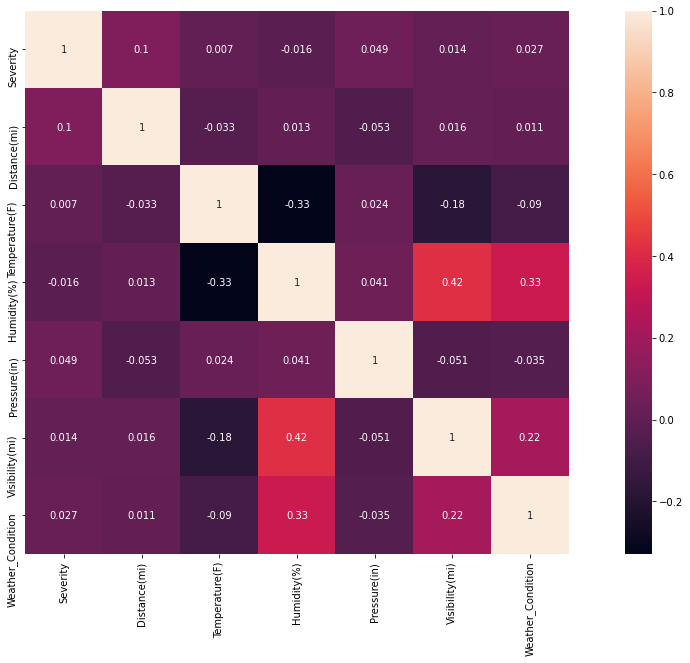

In [ ]:
# create heatmap to look for correlations
nums = train.select_dtypes(include=['int64', 'float64'])
cormat = nums.corr()
plt.figure(figsize=(20,10))
ax = sns.heatmap(cormat, square=True, annot=True)

Nautical and Astronomical Twilight begin after Civil Twilight has begun. Civil Twilight also affects driving more than any of the other twilight variables. I'll keep Civil_Twilight and drop the rest.

In [ ]:
train.drop(['Sunrise_Sunset', 'Nautical_Twilight', 'Astronomical_Twilight'], axis=1, inplace=True)
test.drop(['Sunrise_Sunset', 'Nautical_Twilight', 'Astronomical_Twilight'], axis=1, inplace=True)

Looking at the relationships between several of the features I just created and the outcome

In [ ]:
# sns.set_palette('viridis')
# ax = sns.countplot(x='Severity', hue='Weather_Condition', data=train)
# plt.show()

# sns.set_palette('viridis')
# ax = sns.countplot(x='Severity', hue='Visibility(mi)', data=train)
# plt.show()

# sns.set_palette('viridis')
# ax = sns.countplot(x='Severity', hue='Civil_Twilight', data=train)
# plt.show()

# sns.set_palette('viridis')
# ax = sns.countplot(x='Severity', hue='Distance(mi)', data=train)
# plt.show()

Checking the class distribution of the target variable. Both the histogram and the value counts show a large imbalance. Class 2 has over 100x as many entries as Class 1.  Since the value counts for the highest and lowest class are so small, I'll break this variable into high and low severity.

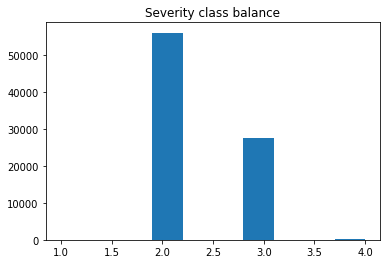

2    55957
3    27531
4      335
1       42
Name: Severity, dtype: int64


In [ ]:
# check class balance of target variable
plt.hist(train['Severity'])
plt.title('Severity class balance')
plt.show()

print(train['Severity'].value_counts())

Even after doing this, there is still a class imbalance. I might balance the training set later

In [ ]:
# Set severity values 1 & 2 to low(0) and 3 & 4 to high(1)
train['Severity'] = np.where(((train['Severity'] == 1) | (train['Severity'] == 2)), 0, 1)
test['Severity'] = np.where(((test['Severity'] == 1) | (test['Severity'] == 2)), 0, 1)
train['Severity'].value_counts()

0    55999
1    27866
Name: Severity, dtype: int64

In [ ]:
# Divide into features and target
X_train = train.drop('Severity', axis=1)
y_train = train['Severity']
X_test = test.drop('Severity', axis=1)
y_test = test['Severity']

# Scaling and feature encoding:
---

The features are on different scales (temp, miles, in) so I'll use StandardScaler to standardize them. I also need to encode several of my categorical variables. Using ColumnTransformer to do both. 

In [ ]:
# use ColumnTransformer to scale some columns and encode others
objs = ['Side', 'Timezone', 'Civil_Twilight']
nums = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Distance(mi)']

sc = StandardScaler()
onehot = OneHotEncoder(drop='first', sparse=False)

preprocessor = ColumnTransformer(transformers=[('num', sc, nums),
                                               ('cat', onehot, objs)])

scaled_train = preprocessor.fit_transform(X_train)
scaled_test = preprocessor.transform(X_test)

In [ ]:
# put results back into dataframes with labeled columns
onehot_features = preprocessor.named_transformers_['cat'].get_feature_names()
all_features = nums + list(onehot_features)

scaled_train = pd.DataFrame(scaled_train, index=X_train.index, columns=all_features)
scaled_test = pd.DataFrame(scaled_test, index=X_test.index, columns=all_features)

In [ ]:
# concatenate results from above with untouched features
train_concat = X_train.drop(['Civil_Twilight', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Distance(mi)', 'Side', 'Timezone'], axis=1)
test_concat = X_test.drop(['Civil_Twilight', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Distance(mi)', 'Side', 'Timezone'], axis=1)

scaled_train = pd.concat([scaled_train, train_concat], axis=1)
scaled_test = pd.concat([scaled_test, test_concat], axis=1)

# Modeling:
---

As I start modeling I'm thinking about what I really want to get out of my model. Since I care the most about finding any accidents that will have a large impact on traffic, I mostly care about my minority class recall. 

<br>

I'm less concerned with the precision because it would be significantly eaiser to correct for a false positive (traffic jam predicted but real time data shows that traffic is flowing freely so no need to reroute cars) than a false negative (no traffic jam was predicted but one started anyway). 

Starting with a gradient boosting classifier with default parameters (except max_depth to avoid overfitting). The model performs decently on the majority class, but minority class recall is very low. 

I'll balance the target variable to see if that helps. 

In [ ]:
gbc = GradientBoostingClassifier(max_depth=10)
gbc.fit(scaled_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
print('Training recall score: ', round(recall_score(y_train, gbc.predict(scaled_train)), 2))
print(classification_report(y_train, gbc.predict(scaled_train)))

Training recall score:  0.58
              precision    recall  f1-score   support

           0       0.81      0.88      0.84     55999
           1       0.71      0.58      0.64     27866

    accuracy                           0.78     83865
   macro avg       0.76      0.73      0.74     83865
weighted avg       0.78      0.78      0.78     83865



Using SMOTE to balance my target variable. This should help improve my scores.

After doing this my training and testing data will look very different, so cross validation won't be very helpful. I'll hold out a random sample of the training data to compare my scores to.

In [ ]:
all = pd.concat([scaled_train, y_train], axis=1)

hold = all.sample(frac=.1)
use = all.drop(hold.index)

In [ ]:
scaled_train = use.drop('Severity', axis=1)
y_train = use['Severity']
X_hold = hold.drop('Severity', axis=1)
y_hold = hold['Severity']

In [ ]:
# resample minority class and equalize class balance
smote = SMOTEENN(sampling_strategy=1.0)
X_train_samp, y_train_samp = smote.fit_resample(scaled_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
# put results back into Series and DataFrame
y_train = pd.Series(y_train_samp, name='Severity')
col_names = list(scaled_train.columns)
scaled_train = pd.DataFrame(X_train_samp, columns=col_names)

In [ ]:
# check distribution after balancing
y_train.value_counts()

1    26127
0    23604
Name: Severity, dtype: int64

Running the same model as above, again with default parameters. This time the outcome variable is balanced. 

Scores increased across the board. I'll try a few other models and adjust hyperparameters to improve my results. 


In [ ]:
gbc = GradientBoostingClassifier(max_depth=10)
gbc.fit(scaled_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
print_score(gbc, recall_score, scaled_train, X_hold, y_train, y_hold)
print_classif_rep(gbc, scaled_train, X_hold, y_train, y_hold)

Train score:  1.0
Test score:  0.84
Training:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95     23604
           1       0.93      1.00      0.96     26127

    accuracy                           0.96     49731
   macro avg       0.96      0.96      0.96     49731
weighted avg       0.96      0.96      0.96     49731

Testing:
               precision    recall  f1-score   support

           0       0.87      0.57      0.69      5569
           1       0.50      0.84      0.62      2817

    accuracy                           0.66      8386
   macro avg       0.69      0.70      0.66      8386
weighted avg       0.75      0.66      0.67      8386



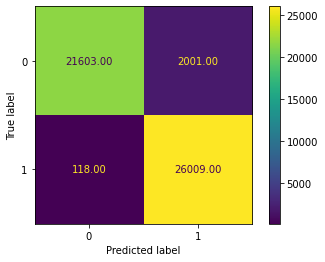

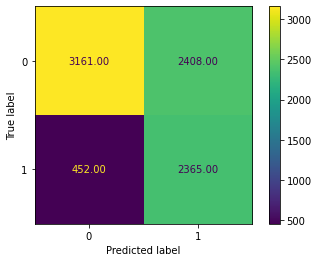

In [ ]:
plot_confusion_matrix(gbc, scaled_train, y_train, values_format='.2f')
plt.show()

plot_confusion_matrix(gbc, X_hold, y_hold, values_format='.2f')
plt.show()

Random forest model with default parameters gets a fairly similar recall score for training data compared to gbc. 

The recall score for the held out data was higher for this model.

In [ ]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(scaled_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print_score(rfc, recall_score, scaled_train, X_hold, y_train, y_hold)
print_classif_rep(rfc, scaled_train, X_hold, y_train, y_hold)

Train score:  0.98
Test score:  0.91
Training:
               precision    recall  f1-score   support

           0       0.97      0.83      0.89     23604
           1       0.86      0.98      0.92     26127

    accuracy                           0.91     49731
   macro avg       0.92      0.90      0.91     49731
weighted avg       0.92      0.91      0.91     49731

Testing:
               precision    recall  f1-score   support

           0       0.91      0.50      0.65      5569
           1       0.48      0.91      0.63      2817

    accuracy                           0.64      8386
   macro avg       0.70      0.70      0.64      8386
weighted avg       0.77      0.64      0.64      8386



XGB with default parameters also gets a similar recall score to the models above. I'll tune the hyperparameters of this model to see if I can improve my results.

Although my results seem to be overfit, this is likely a result of the balanced outcome variable, rather than true overfitting. Because of the training set is synthetically balanced and the training set is not, there is little we can do to reduce the apparent overfitting. 

In [ ]:
xgb = XGBClassifier()
xgb.fit(scaled_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
print_score(xgb, recall_score, scaled_train, X_hold, y_train, y_hold)
print_classif_rep(xgb, scaled_train, X_hold, y_train, y_hold)

Train score:  0.98
Test score:  0.9
Training:
               precision    recall  f1-score   support

           0       0.97      0.83      0.89     23604
           1       0.86      0.98      0.92     26127

    accuracy                           0.91     49731
   macro avg       0.92      0.90      0.90     49731
weighted avg       0.91      0.91      0.90     49731

Testing:
               precision    recall  f1-score   support

           0       0.91      0.50      0.65      5569
           1       0.48      0.90      0.63      2817

    accuracy                           0.64      8386
   macro avg       0.70      0.70      0.64      8386
weighted avg       0.77      0.64      0.64      8386



Since my training and test data was so different, the optimized parameters for my training set actually had worse scores for my held out data. Even using cross validation on my grid search did not improve the scores for my held out data. 

In fact, the best scores I got were on the models with just a max_depth specified.

In [ ]:
grid = {
  'learning_rate': [.001, .01, 1],
  'max_depth': [3, 5, 10],
  'n_estimators': [10, 30]
        }

xgb_grid = GridSearchCV(XGBClassifier(), grid, cv=5)
xgb_grid.fit(scaled_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.001, 0.01, 1],
                         'max_depth': [3, 5, 10], 'n_estimators': [10, 30]},
             pre_dispatch='2*n_jobs', re

In [ ]:
print(xgb_grid.best_params_)
recall_score(y_hold, xgb_grid.predict(X_hold))

{'learning_rate': 1, 'max_depth': 10, 'n_estimators': 30}


0.751863684771033

In [ ]:
print('Recall scores:') 
print_score(xgb_grid, recall_score, scaled_train, X_hold, y_train, y_hold)
print('\n')
print_classif_rep(xgb_grid, scaled_train, X_hold, y_train, y_hold)

Recall scores:
Train score:  0.99
Test score:  0.75


Training:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     23604
           1       0.97      0.99      0.98     26127

    accuracy                           0.98     49731
   macro avg       0.98      0.98      0.98     49731
weighted avg       0.98      0.98      0.98     49731

Testing:
               precision    recall  f1-score   support

           0       0.83      0.62      0.71      5569
           1       0.50      0.75      0.60      2817

    accuracy                           0.67      8386
   macro avg       0.67      0.69      0.66      8386
weighted avg       0.72      0.67      0.68      8386



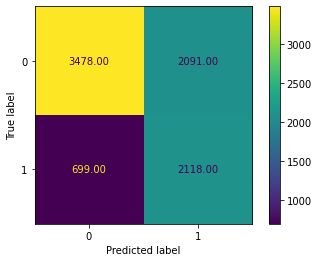

In [ ]:
plot_confusion_matrix(xgb_grid, X_hold, y_hold, values_format='.2f')
plt.show()

Finally time to see the scores for my test set. I'll use the rfc classifier since that had the best scores on my held out data.

Although the final accuracy score was low, the recall was high for my minority class, which is what I was hoping to see. 

In [ ]:
print('Recall score: ', round(recall_score(y_test, rfc.predict(scaled_test)), 2), '\n')
print(classification_report(y_test, rfc.predict(scaled_test)))

Recall score:  0.91 

              precision    recall  f1-score   support

           0       0.92      0.50      0.65     13962
           1       0.48      0.91      0.63      7008

    accuracy                           0.64     20970
   macro avg       0.70      0.71      0.64     20970
weighted avg       0.77      0.64      0.64     20970



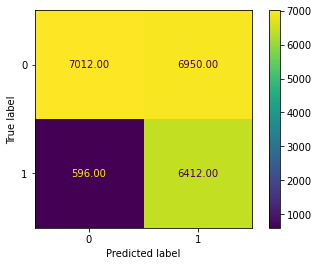

In [ ]:
plot_confusion_matrix(rfc, scaled_test, y_test, values_format='.2f')
plt.show()